In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [190]:
import numpy as np
import pandas as pd
import tensorflow as tf

import scipy.stats as spt

DTYPE = tf.float64

In [5]:
from vegasflow import VegasFlow

In [118]:
m_tf = tf.constant(0.5, dtype=tf.float64)
alpha_tf = tf.constant(0.01 * np.sqrt(2), dtype=tf.float64)
pi_tf = tf.constant(np.pi, dtype=tf.float64)

@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)])
def f1_d8_tf(x):
    pre = 1.0 / (alpha_tf * tf.sqrt(pi_tf)) ** 8
    exponent = -1 * tf.reduce_sum((x - m_tf) ** 2, axis=-1) / alpha_tf ** 2
    return pre * tf.exp(exponent) / 1.


norm_m1, norm_m2, norm_m3 = 0.33, 0.47, 0.67
sigma = 0.01
norm_dist_1 = spt.norm(loc=norm_m1, scale=sigma)
norm_dist_2 = spt.norm(loc=norm_m2, scale=sigma)
norm_dist_3 = spt.norm(loc=norm_m3, scale=sigma)

norm_triple = norm_dist_1.cdf(1) - norm_dist_1.cdf(0) \
            + norm_dist_2.cdf(1) - norm_dist_2.cdf(0) \
            + norm_dist_3.cdf(1) - norm_dist_3.cdf(0)
norm_triple /= 3

dim2target_dict = {
    2: norm_triple ** 2,
    4: norm_triple ** 4,
    6: norm_triple ** 6,
    8: norm_triple ** 8,
}

integ_bounds = [0, 1]

ms_tf = tf.constant([norm_m1, norm_m2, norm_m3], dtype=DTYPE)
alpha_tf = tf.constant(sigma * np.sqrt(2), dtype=DTYPE)
pi_tf = tf.constant(np.pi, dtype=DTYPE)


@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=DTYPE)])
def f2_d6_tf(x):
    pre = 1. / (alpha_tf * tf.sqrt(pi_tf)) ** 6
    exponent1 = -1. * tf.reduce_sum(((x - ms_tf[0]) ** 2), axis=-1) / alpha_tf ** 2
    exponent2 = -1. * tf.reduce_sum(((x - ms_tf[1]) ** 2), axis=-1) / alpha_tf ** 2
    exponent3 = -1. * tf.reduce_sum(((x - ms_tf[2]) ** 2), axis=-1) / alpha_tf ** 2
    res = pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))
    return res / dim2target_dict[6]

@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=DTYPE)])
def f2_d8_tf(x):
    pre = 1. / (alpha_tf * tf.sqrt(pi_tf)) ** 8
    exponent1 = -1. * tf.reduce_sum(((x - ms_tf[0]) ** 2), axis=-1) / alpha_tf ** 2
    exponent2 = -1. * tf.reduce_sum(((x - ms_tf[1]) ** 2), axis=-1) / alpha_tf ** 2
    exponent3 = -1. * tf.reduce_sum(((x - ms_tf[2]) ** 2), axis=-1) / alpha_tf ** 2
    res = pre / 3 * (tf.exp(exponent1) + tf.exp(exponent2) + tf.exp(exponent3))
    return res / dim2target_dict[8]


dim2target_dict = {
        # from 0 to 10
        2: 8 * np.cos(5) * np.sin(5) ** 3,    
        4: 32 * (np.cos(5) + np.cos(15)) * np.sin(5) ** 5,
        6: 128 * (np.cos(5) + np.cos(15) + np.cos(25)) * np.sin(5) ** 7,
        8: 128 * (np.cos(35) - np.cos(45)) * np.sin(5) ** 7,
    }

integ_bounds = [0, 10]
integ_size = integ_bounds[1] - integ_bounds[0]

@tf.function(input_signature=[tf.TensorSpec(shape=(None,2), dtype=tf.float64)])
def f3_d2_tf(x):
    return tf.sin(tf.reduce_sum(x * integ_size, axis=-1)) * integ_size ** 2 / dim2target_dict[2]

@tf.function(input_signature=[tf.TensorSpec(shape=(None,4), dtype=tf.float64)])
def f3_d4_tf(x):
    return tf.sin(tf.reduce_sum(x * integ_size, axis=-1)) * integ_size ** 4 / dim2target_dict[4]

@tf.function(input_signature=[tf.TensorSpec(shape=(None,6), dtype=tf.float64)])
def f3_d6_tf(x):
    return tf.sin(tf.reduce_sum(x * integ_size, axis=-1)) * integ_size ** 6 / dim2target_dict[6]

@tf.function(input_signature=[tf.TensorSpec(shape=(None,8), dtype=tf.float64)])
def f3_d8_tf(x):
    return tf.sin(tf.reduce_sum(x * integ_size, axis=-1)) * integ_size ** 8 / dim2target_dict[8]

In [156]:
ndims = 8
integrand = f3_d8_tf

In [214]:
vegas_integ = VegasFlow(
    n_dim=ndims,
    n_events=int(2e7),
    events_limit=int(2e6),
    verbose=True,
    list_devices=['GPU'],
)      

In [215]:
vegas_integ.compile(integrand, compilable=True)

In [216]:
print(vegas_integ.devices)

{'/device:GPU:0': True}


In [217]:
vegas_integ.run_integration(5)

[INFO] (vegasflow.monte_carlo) Result for iteration 0: -1.933e+01 +/- 9.468e+01(took 4.96173 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 77.2050 +/- 94.6549(took 4.67649 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: -7.426e+01 +/- 9.466e+01(took 4.52989 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: -1.931e+01 +/- 9.466e+01(took 4.63959 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 14.1431 +/- 94.6704(took 4.57277 s)
[INFO] (vegasflow.monte_carlo)  > Final results: -4.30998 +/- 42.3355


(-4.3099801066933106, 42.33552676677312)

In [218]:
vegas_integ.run_integration(10)

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 12.2297 +/- 94.6563(took 4.93480 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: -1.605e+02 +/- 9.467e+01(took 4.57576 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 7.1656 +/- 94.6647(took 4.57676 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 71.3313 +/- 94.6736(took 4.55183 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 51.2421 +/- 94.6650(took 4.77922 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: -1.741e+01 +/- 9.467e+01(took 4.57676 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: -8.647e+01 +/- 9.466e+01(took 4.62164 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 7: -7.241e+01 +/- 9.467e+01(took 4.54883 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 8: -1.995e+01 +/- 9.467e+01(took 4.63062 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 9: -9.762e+00 +/- 9.467e+01(took 4.74830 s)
[INFO] (vegasflow.monte_carlo)  > Final results: -22.4499 +/- 29.936


(-22.449922020459063, 29.935985429951817)

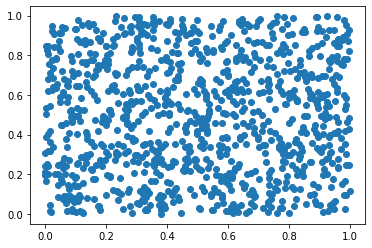

In [213]:
import matplotlib.pyplot as plt
%matplotlib inline

tt = vegas_integ.generate_random_array(1000)[0].numpy()[:,:2]
plt.scatter(tt[:,0], tt[:,1])

In [195]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [196]:
def compute_variance_weighted_result(means, sdevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert means.size == sdevs.size
    assert means.shape == sdevs.shape
    var = 1./np.sum(1./sdevs**2, axis=-1)
    mean = np.sum(means/(sdevs**2), axis=-1)
    mean *= var
    return mean, np.sqrt(var)

### LDSeq

In [6]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_LDSeq/f1_run2_fp',
    'f1_run2': 'result/06_Comp_LDSeq/f1_run3_fp',
    'f1_run3': 'result/06_Comp_LDSeq/f1_run4_fp',
        
    'f2_run1': 'result/06_Comp_LDSeq/f2_run1_fp',
    'f2_run2': 'result/06_Comp_LDSeq/f2_run2_fp',
    'f2_run3': 'result/06_Comp_LDSeq/f2_run3_fp',
    
    'f3_run1': 'result/06_Comp_LDSeq/f3_run1_fp',
    'f3_run2': 'result/06_Comp_LDSeq/f3_run2_fp',
    'f3_run3': 'result/06_Comp_LDSeq/f3_run3_fp',
    
}

In [7]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [8]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
0,f1,8,15,8000000,2.233573e-33,1.908384e-33,5.240036e+32,589.177,1.771,15.407984,0.350846,2
1,f1,6,15,8000000,4.297898e-06,2.493957e-06,4.009674e+05,284.830,0.143,19.053020,0.162933,2
2,f1,4,15,8000000,1.010345e+00,7.416427e-02,1.394828e-01,180.370,0.000,4.112387,0.994751,2
3,f1,2,15,8000000,9.999976e-01,2.573552e-03,9.170684e-04,84.571,0.001,0.001425,1.000000,2
0,f1,8,15,8000000,4.799328e-29,3.517891e-29,2.842612e+28,574.607,1.451,15.280811,0.359232,3
1,f1,6,15,8000000,2.348684e-06,1.419931e-06,7.042580e+05,284.114,0.002,20.143617,0.125678,3
2,f1,4,15,8000000,9.831583e-01,7.118668e-02,2.365848e-01,179.825,0.001,1.726977,0.999966,3
3,f1,2,15,8000000,1.000033e+00,2.573643e-03,1.268688e-02,84.499,0.002,0.001515,1.000000,3
0,f1,8,15,8000000,1.233723e-36,1.095327e-36,9.129696e+35,603.118,1.427,15.679741,0.333321,4
1,f1,6,15,8000000,4.717529e-06,1.762592e-06,5.673437e+05,283.823,0.002,14.264053,0.430230,4


In [10]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'ldseq'
agg_df  #.reset_index()

res_mean                     res_err  \
                                mean           std          mean   
func ndim nitn neval                                               
f1   2    15   8000000  1.000020e+00  1.920889e-05  2.573598e-03   
     4    15   8000000  9.827032e-01  2.787171e-02  7.112798e-02   
     6    15   8000000  3.788037e-06  1.264051e-06  1.892160e-06   
     8    15   8000000  1.599851e-29  2.770829e-29  1.172694e-29   
f2   2    15   8000000  1.000002e+00  1.090654e-05  1.483957e-03   
     4    15   8000000  9.836375e-01  1.115930e-02  4.127122e-02   
     6    15   8000000  1.280414e-04  1.299131e-04  5.324295e-05   
     8    15   8000000  3.361009e-23  2.988023e-23  2.436813e-23   
f3   2    15   8000000  6.904925e-04  1.311635e-05  3.225874e-03   
     4    15   8000000  4.179247e-03  2.534981e-02  5.226239e-02   
     6    15   8000000  2.501432e-02  8.240949e-01  1.312925e+00   
     8    15   8000000 -2.874745e+01  6.019535e+01  4.733282e+01   

                                           res_rel                total_time  \
                                 std          mean           std        mean   
func ndim nitn neval                                                           
f1   2    15   8000000  4.550468e-08  8.270254e-03  6.410900e-03   84.694000   
     4    15   8000000  3.066064e-03  3.477637e-01  2.808881e-01  180.083000   
     6    15   8000000  5.486112e-07  5.575230e+05  1.518836e+05  284.255667   
     8    15   8000000  2.031000e-29  3.044979e+35  5.269520e+35  588.967333   
f2   2    15   8000000  1.035638e-08  5.067460e-03  4.416023e-03   86.668667   
     4    15   8000000  8.869933e-04  4.004393e-01  2.823121e-01  182.076333   
     6    15   8000000  5.365093e-05  6.581750e+04  8.596904e+04  284.198667   
     8    15   8000000  2.154887e-23  6.120501e+24  1.055284e+25  585.097667   
f3   2    15   8000000  1.203963e-09  3.097795e+02  4.036054e-03   84.456667   
     4    15   8000000  5.318093e-07  1.905425e+01  4.852452e-01  180.060667   
     6    15   8000000  2.602735e-05  7.426054e-01  6.276776e-01  284.278667   
     8    15   8000000  5.684809e-04  7.823557e-01  1.136547e+00  569.913667   

                                   pre_time                 chi2            \
                              std      mean       std       mean       std   
func ndim nitn neval                                                         
f1   2    15   8000000   0.277739  0.001667  0.000577   0.001282  0.000328   
     4    15   8000000   0.273655  0.001000  0.001000   3.841395  1.992790   
     6    15   8000000   0.518232  0.049000  0.081406  17.820230  3.127642   
     8    15   8000000  14.256656  1.549667  0.192056  15.456179  0.203785   
f2   2    15   8000000   0.328550  0.002000  0.000000   0.001332  0.000556   
     4    15   8000000   1.890313  0.001333  0.000577   5.210923  1.633178   
     6    15   8000000   6.544535  0.002333  0.001528  18.664018  1.129332   
     8    15   8000000   8.886828  2.341667  1.454951  16.070199  1.195444   
f3   2    15   8000000   0.468036  0.001333  0.000577   0.000749  0.000611   
     4    15   8000000   1.221525  0.002000  0.000000  12.286905  8.362698   
     6    15   8000000   0.851002  0.001667  0.001155  16.429846  5.194724   
     8    15   8000000   7.664516  1.555333  0.243430  13.338929  7.573264   

                               Q            itype  
                            mean       std         
func ndim nitn neval                               
f1   2    15   8000000  1.000000  0.000000  ldseq  
     4    15   8000000  0.989513  0.013837  ldseq  
     6    15   8000000  0.239614  0.166126  ldseq  
     8    15   8000000  0.347800  0.013222  ldseq  
f2   2    15   8000000  1.000000  0.000000  ldseq  
     4    15   8000000  0.973704  0.028391  ldseq  
     6    15   8000000  0.181289  0.047432  ldseq  
     8    15   8000000  0.312679  0.075101  ldseq  
f3   2    15   8000000  1.000000  0.000000  ldseq  
     4    1

In [100]:
means_sdevs_dict ={
    'f1_run2_d2': 'result/06_Comp_LDSeq/f1_run2_fp_d2_means_sdevs.npy',
    'f1_run2_d4': 'result/06_Comp_LDSeq/f1_run2_fp_d4_means_sdevs.npy',
    'f1_run2_d6': 'result/06_Comp_LDSeq/f1_run2_fp_d6_means_sdevs.npy',
    'f1_run2_d8': 'result/06_Comp_LDSeq/f1_run2_fp_d8_means_sdevs.npy',
    
    'f2_run2_d2': 'result/06_Comp_LDSeq/f2_run2_fp_d2_means_sdevs.npy',
    'f2_run2_d4': 'result/06_Comp_LDSeq/f2_run2_fp_d4_means_sdevs.npy',
    'f2_run2_d6': 'result/06_Comp_LDSeq/f2_run2_fp_d6_means_sdevs.npy',
    'f2_run2_d8': 'result/06_Comp_LDSeq/f2_run2_fp_d8_means_sdevs.npy',
    
    'f3_run2_d2': 'result/06_Comp_LDSeq/f3_run2_fp_d2_means_sdevs.npy',
    'f3_run2_d4': 'result/06_Comp_LDSeq/f3_run2_fp_d4_means_sdevs.npy',
    'f3_run2_d6': 'result/06_Comp_LDSeq/f3_run2_fp_d6_means_sdevs.npy',
    'f3_run2_d8': 'result/06_Comp_LDSeq/f3_run2_fp_d8_means_sdevs.npy',
    
}


stat_df = pd.DataFrame()

for k,v in means_sdevs_dict.items():
    
    func, run_num, ndim = k.split('_')
    
    arr = np.load(v)
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndim'] = int(ndim[1:])
    temp_df['run_num'] = int(run_num[3:])
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndim', 'itype', *range(15), 'run_num']]

In [101]:
stat_df

,func,ndim,itype,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,run_num
0,f1,2,mean,9.999775e-01,1.000075e+00,1.000096,9.998716e-01,1.000020e+00,9.999715e-01,1.000128e+00,1.000030e+00,1.000169e+00,9.997775e-01,9.999929e-01,9.999242e-01,1.000038e+00,9.999639e-01,9.999311e-01,2
1,f1,2,sdev,9.966589e-03,9.968393e-03,0.009969,9.966149e-03,9.967051e-03,9.967048e-03,9.968392e-03,9.967261e-03,9.969416e-03,9.965491e-03,9.966754e-03,9.966519e-03,9.967801e-03,9.967174e-03,9.966739e-03,2
0,f1,4,mean,1.084689e+00,1.103203e+00,0.926479,7.702783e-01,1.148402e+00,1.286830e+00,1.066530e+00,1.025590e+00,1.116270e+00,9.641953e-01,1.140330e+00,9.823417e-01,1.182366e+00,1.035307e+00,1.196431e+00,2
1,f1,4,sdev,2.799524e-01,2.859621e-01,0.279227,1.587191e-01,3.447102e-01,3.817759e-01,2.892980e-01,3.292764e-01,2.959155e-01,2.906209e-01,3.362080e-01,3.146379e-01,3.554606e-01,3.234400e-01,3.498986e-01,2
0,f1,6,mean,2.072744e-03,3.212079e-06,0.000021,1.822201e-04,1.723437e-04,6.402230e-05,1.079027e-02,3.424776e-03,1.227913e-03,8.627934e-05,5.075495e-02,4.643299e-02,2.490552e+01,1.983597e-03,1.345827e-03,2
1,f1,6,sdev,1.740279e-03,2.552915e-06,0.000012,1.624421e-04,1.713018e-04,4.514844e-05,7.085113e-03,3.276341e-03,1.210686e-03,8.461908e-05,3.557433e-02,4.393743e-02,2.490272e+01,1.799178e-03,1.343493e-03,2
0,f1,8,mean,2.233561e-33,3.727966e-22,0.000131,3.107651e-17,8.212852e-10,1.282859e-20,9.891405e-17,7.983237e-16,3.075247e-28,7.940779e-23,2.432686e-26,4.880929e-17,8.857813e-20,4.148685e-22,1.560868e-19,2
1,f1,8,sdev,1.908384e-33,3.727947e-22,0.000131,3.107651e-17,8.212852e-10,1.090053e-20,9.890968e-17,7.983229e-16,3.075242e-28,7.762801e-23,2.430540e-26,3.477489e-17,8.857665e-20,4.139087e-22,1.560868e-19,2
0,f2,2,mean,9.999353e-01,1.000057e+00,1.000091,9.999500e-01,1.000021e+00,1.000072e+00,1.000091e+00,9.999256e-01,1.000022e+00,1.000088e+00,1.000019e+00,9.999556e-01,9.999664e-01,1.000020e+00,1.000008e+00,2
1,f2,2,sdev,5.746819e-03,5.747431e-03,0.005748,5.746935e-03,5.747482e-03,5.747669e-03,5.747497e-03,5.747191e-03,5.747510e-03,5.747697e-03,5.747131e-03,5.747409e-03,5.747304e-03,5.747220e-03,5.747205e-03,2


In [147]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(15)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(15)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,16)]    
    # w_arr = [(x[0],y[0]) for x,y in w_arr]
#     print(w_arr)
    w_arr = np.array(w_arr).T
#     print(w_arr)
#     print('---------------------')
    return pd.concat([x[['func', 'ndim', 'itype']], pd.DataFrame(w_arr)], axis=1)

a = stat_df.groupby(['func', 'ndim'], as_index=False).apply(temp_foo).reset_index(drop=True)
a

,func,ndim,itype,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,f1,2,mean,9.999775e-01,1.000026e+00,1.000050e+00,1.000005e+00,1.000008e+00,1.000002e+00,1.000020e+00,1.000021e+00,1.000037e+00,1.000011e+00,1.000010e+00,1.000003e+00,1.000005e+00,1.000002e+00,9.999976e-01
1,f1,2,sdev,9.966589e-03,7.048081e-03,5.755045e-03,4.983780e-03,4.457583e-03,4.069170e-03,3.767373e-03,3.524043e-03,3.322571e-03,3.151997e-03,3.005291e-03,2.877325e-03,2.764454e-03,2.663891e-03,2.573552e-03
2,f1,4,mean,1.084689e+00,1.093749e+00,1.037014e+00,9.004088e-01,9.246978e-01,9.514751e-01,9.646008e-01,9.695370e-01,9.829021e-01,9.812879e-01,9.909207e-01,9.903658e-01,9.996269e-01,1.001591e+00,1.010345e+00
3,f1,4,sdev,2.799524e-01,2.000471e-01,1.626198e-01,1.135854e-01,1.078796e-01,1.038146e-01,9.771358e-02,9.367595e-02,8.930790e-02,8.536801e-02,8.274237e-02,8.002161e-02,7.806784e-02,7.588857e-02,7.416427e-02
4,f1,6,mean,2.072744e-03,3.216532e-06,3.948020e-06,3.990215e-06,4.026040e-06,4.209271e-06,4.210609e-06,4.212593e-06,4.217790e-06,4.289072e-06,4.289322e-06,4.289471e-06,4.289472e-06,4.293275e-06,4.297898e-06
5,f1,6,sdev,1.740279e-03,2.552913e-06,2.499435e-06,2.499139e-06,2.498873e-06,2.495054e-06,2.495054e-06,2.495053e-06,2.495048e-06,2.493964e-06,2.493964e-06,2.493964e-06,2.493964e-06,2.493962e-06,2.493957e-06
6,f1,8,mean,2.233561e-33,2.233561e-33,2.233561e-33,2.233561e-33,2.233561e-33,2.233561e-33,2.233561e-33,2.233561e-33,2.233573e-33,2.233573e-33,2.233573e-33,2.233573e-33,2.233573e-33,2.233573e-33,2.233573e-33
7,f1,8,sdev,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33,1.908384e-33
8,f2,2,mean,9.999353e-01,9.999959e-01,1.000028e+00,1.000008e+00,1.000011e+00,1.000021e+00,1.000031e+00,1.000018e+00,1.000018e+00,1.000025e+00,1.000025e+00,1.000019e+00,1.000015e+00,1.000015e+00,1.000015e+00
9,f2,2,sdev,5.746819e-03,4.063831e-03,3.318266e-03,2.873644e-03,2.570283e-03,2.346360e-03,2.172313e-03,2.032003e-03,1.915796e-03,1.817494e-03,1.732904e-03,1.659130e-03,1.594039e-03,1.536051e-03,1.483963e-03


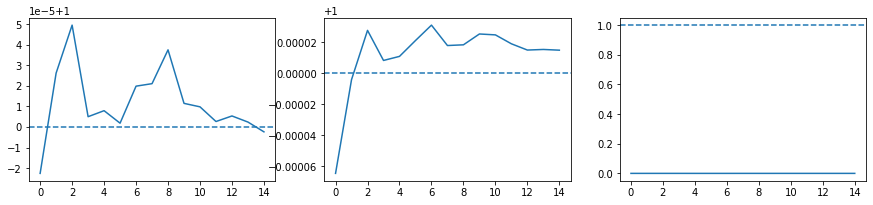

In [185]:
fig = plt.figure(figsize=(15,3))

ax = fig.add_subplot(1,3,1)
ax.axhline(1, linestyle='--')
ax.plot(range(15),
         a.loc[(a.func == 'f1') & (a['ndim'] == 2) & (a['itype'] == 'mean')].iloc[0][[*range(15)]].values)

ax = fig.add_subplot(1,3,2)
ax.axhline(1, linestyle='--')
ax.plot(range(15),
         a.loc[(a.func == 'f2') & (a['ndim'] == 2) & (a['itype'] == 'mean')].iloc[0][[*range(15)]].values)

ax = fig.add_subplot(1,3,3)
ax.axhline(1, linestyle='--')
ax.plot(range(15),
         a.loc[(a.func == 'f3') & (a['ndim'] == 2) & (a['itype'] == 'mean')].iloc[0][[*range(15)]].values)

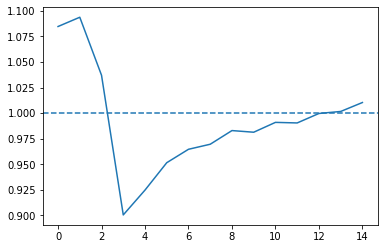

In [169]:
plt.axhline(1, linestyle='--')
plt.plot(range(15),
         a.loc[(a.func == 'f1') & (a['ndim'] == 4) & (a['itype'] == 'mean')].iloc[0][[*range(15)]].values)

### RSobol

#### Plot

In [167]:
temp_folder = 'result/02_LDS_RSobol_seed'

In [168]:
[f for f in os.listdir(temp_folder) if f.endswith('.npy')][0]

'f1_run1_fp_d2_means_sdevs.npy'

In [169]:
stat_df = pd.DataFrame()

for fname in [f for f in os.listdir(temp_folder) if f.endswith('.npy')]:
    
    func, run_num, _, ndims, _, _ = fname.split('_')
    run_num = int(run_num[-1])
    ndims = int(ndims[-1])
    
    arr = np.load(os.path.join(temp_folder,fname))
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndims'] = ndims
    temp_df['run_num'] = run_num
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndims', 'itype', *range(5,15), 'run_num']]

In [170]:
stat_df

,func,ndims,itype,5,6,7,8,9,10,11,12,13,14,run_num
0,f1,2,mean,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
1,f1,2,sdev,0.009734,0.009734,0.009734,0.009734,0.009734,0.009734,0.009734,0.009734,0.009734,0.009734,1
0,f1,4,mean,1.018281,1.443268,1.273280,1.013052,0.969743,1.238797,1.441319,0.390763,1.001222,0.894070,1
1,f1,4,sdev,0.297689,0.377154,0.305736,0.284191,0.245957,0.351513,0.346909,0.071710,0.263344,0.218056,1
0,f1,6,mean,0.000299,0.000120,0.000210,0.008290,0.000005,0.005909,0.000019,0.002915,0.001737,0.844867,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,f3,4,sdev,0.197669,0.197667,0.197668,0.197673,0.197669,0.197669,0.197669,0.197669,0.197669,0.197669,5
0,f3,6,mean,0.047262,-0.385027,0.119248,-0.036759,0.047366,0.032574,0.171003,-0.231059,-0.198880,0.175309,5
1,f3,6,sdev,4.965644,4.965872,4.965889,4.965793,4.965723,4.965656,4.965695,4.965829,4.965520,4.965901,5
0,f3,8,mean,0.996034,453.558852,41.274205,19.694367,-121.728126,0.947683,58.081654,12.677525,29.597471,-72.679827,5


In [171]:
agg_stat_df = stat_df.groupby(['func', 'ndims', 'itype']).mean().reset_index().drop('run_num', axis=1)
agg_stat_df

,func,ndims,itype,5,6,7,8,9,10,11,12,13,14
0,f1,2,mean,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,f1,2,sdev,9.733681e-03,9.733681e-03,9.733679e-03,9.733680e-03,9.733680e-03,9.733681e-03,9.733681e-03,9.733668e-03,9.733681e-03,9.733681e-03
2,f1,4,mean,1.018281e+00,1.443268e+00,1.273280e+00,1.013052e+00,9.697433e-01,1.238797e+00,1.441319e+00,3.907630e-01,1.001222e+00,8.940703e-01
3,f1,4,sdev,2.976890e-01,3.771545e-01,3.057355e-01,2.841909e-01,2.459567e-01,3.515132e-01,3.469088e-01,7.170950e-02,2.633442e-01,2.180558e-01
4,f1,6,mean,2.989885e-04,1.198525e-04,2.099686e-04,8.289682e-03,5.009532e-06,5.909179e-03,1.856856e-05,2.915047e-03,1.737264e-03,8.448670e-01
5,f1,6,sdev,2.243732e-04,8.057512e-05,2.090822e-04,8.289411e-03,3.492469e-06,5.626895e-03,1.840972e-05,2.915031e-03,1.639654e-03,8.206029e-01
6,f1,8,mean,2.193037e-18,9.961433e-25,7.917435e-10,3.185917e-13,8.269180e-12,1.794489e-18,1.565502e-17,1.342574e-26,1.563028e-06,4.099200e-26
7,f1,8,sdev,2.143945e-18,9.945494e-25,7.917435e-10,3.185911e-13,8.261880e-12,1.794487e-18,1.539803e-17,1.027449e-26,1.562786e-06,4.099199e-26
8,f2,2,mean,1.000000e+00,9.999996e-01,9.999998e-01,9.999999e-01,9.999999e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.999993e-01,1.000002e+00
9,f2,2,sdev,5.612667e-03,5.612663e-03,5.612667e-03,5.612668e-03,5.612668e-03,5.612674e-03,5.612669e-03,5.612662e-03,5.612670e-03,5.612709e-03


In [172]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(5,15)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(5,15)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,11)]
    w_arr = np.array(w_arr).T
    temp_df = pd.DataFrame(w_arr)
    return pd.concat([x[['func', 'ndims', 'itype']].reset_index(drop=True), temp_df], axis=1)#, ignore_index=True)

a = agg_stat_df.groupby(['func', 'ndims'], as_index=False).apply(temp_foo).reset_index(drop=True)
a

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,f1,2,sdev,9.733681e-03,6.882752e-03,5.619743e-03,4.866840e-03,4.353034e-03,3.973758e-03,3.678985e-03,3.441375e-03,3.244560e-03,3.078060e-03
2,f1,4,mean,1.018281e+00,1.181415e+00,1.215289e+00,1.154797e+00,1.101987e+00,1.118758e+00,1.154819e+00,6.020401e-01,6.223641e-01,6.411460e-01
3,f1,4,sdev,2.976890e-01,2.336704e-01,1.856552e-01,1.554283e-01,1.313919e-01,1.230750e-01,1.159915e-01,6.099439e-02,5.942137e-02,5.733081e-02
4,f1,6,mean,2.989885e-04,1.403152e-04,1.484129e-04,1.490149e-04,5.354346e-06,5.356615e-06,5.814522e-06,5.818543e-06,5.826108e-06,5.826123e-06
5,f1,6,sdev,2.243732e-04,7.583355e-05,7.128935e-05,7.128671e-05,3.488285e-06,3.488284e-06,3.427302e-06,3.427300e-06,3.427292e-06,3.427292e-06
6,f1,8,mean,2.193037e-18,9.961438e-25,9.961438e-25,9.961438e-25,9.961438e-25,9.961443e-25,9.961444e-25,1.353061e-26,1.353061e-26,1.515369e-26
7,f1,8,sdev,2.143945e-18,9.945494e-25,9.945494e-25,9.945494e-25,9.945494e-25,9.945494e-25,9.945494e-25,1.027394e-26,1.027394e-26,9.965700e-27
8,f2,2,mean,1.000000e+00,9.999998e-01,9.999998e-01,9.999998e-01,9.999998e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,1.000000e+00
9,f2,2,sdev,5.612667e-03,3.968753e-03,3.240474e-03,2.806333e-03,2.510061e-03,2.291362e-03,2.121389e-03,1.984378e-03,1.870889e-03,1.774883e-03


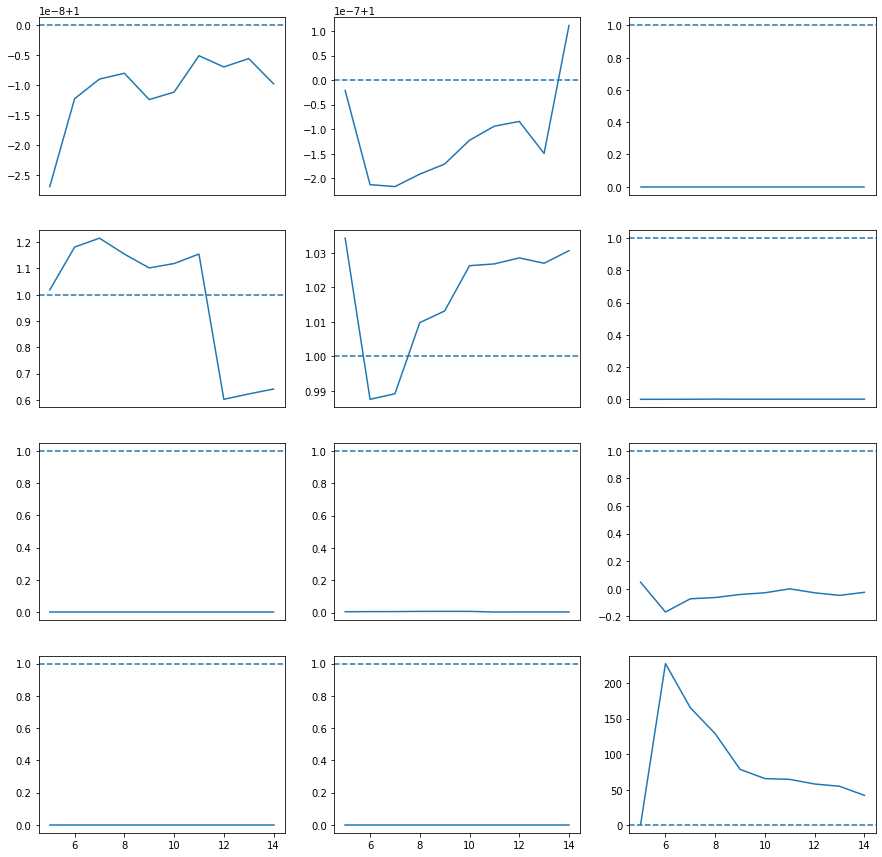

In [173]:
fig = plt.figure(figsize=(15,15))

for i, ndims in enumerate([2,4,6,8], 0):
    for j, func in enumerate(['f1','f2','f3'], 0):
        
        ax = fig.add_subplot(4,3, i*3+j+1)
        temp_xx = np.arange(5,15)
        temp_yy = a.loc[(a.func == func) & (a['ndims'] == ndims) & (a['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        
        ax.plot(temp_xx, temp_yy, label='sobol')
        ax.axhline(1, linestyle='--')
        # ax.legend()
        
        if i < 3:
            ax.set_xticks([])


### Vegas

In [11]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_Vegas/f1_run2_fp',
    'f1_run2': 'result/06_Comp_Vegas/f1_run3_fp',
    'f1_run3': 'result/06_Comp_Vegas/f1_run4_fp',
        
    'f2_run1': 'result/06_Comp_Vegas/f2_run1_fp',
    'f2_run2': 'result/06_Comp_Vegas/f2_run2_fp',
    'f2_run3': 'result/06_Comp_Vegas/f2_run3_fp',
    
    'f3_run1': 'result/06_Comp_Vegas/f3_run1_fp',
    'f3_run2': 'result/06_Comp_Vegas/f3_run2_fp',
    'f3_run3': 'result/06_Comp_Vegas/f3_run3_fp',
}

In [12]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [13]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,ncall,avg_neval,chi2,Q,run_num
0,f1,8,15,10000000,1.000030,0.000100,0.303503,57.945,19.551,3450,8547187.0,3.644498,0.933216,2
1,f1,6,15,10000000,0.999895,0.000068,1.537026,46.483,15.353,3465,8558940.5,5.044093,0.830448,2
2,f1,4,15,10000000,1.000051,0.000043,1.187420,37.082,12.960,3765,9002218.7,8.887863,0.447689,2
3,f1,2,15,10000000,1.000000,0.000003,0.128476,15.974,5.678,3630,4805000.0,4.784969,0.852636,2
0,f1,8,15,10000000,0.999867,0.000101,1.322553,58.797,20.316,3450,8560329.4,12.633296,0.179913,3
1,f1,6,15,10000000,0.999962,0.000068,0.551754,46.269,15.422,3465,8558567.4,4.549061,0.871715,3
2,f1,4,15,10000000,1.000011,0.000043,0.252019,38.028,13.285,3765,9000613.1,3.640003,0.933471,3
3,f1,2,15,10000000,0.999999,0.000003,0.297437,15.932,5.671,3630,4805000.0,11.773117,0.226404,3
0,f1,8,15,10000000,0.999895,0.000103,1.023041,57.953,19.632,3450,8566756.2,15.505813,0.077947,4
1,f1,6,15,10000000,1.000049,0.000067,0.735727,47.146,16.112,3465,8559926.4,3.283802,0.951973,4


In [14]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'vegas'
agg_df  #.reset_index()

res_mean               res_err                \
                              mean        std       mean           std   
func ndim nitn neval                                                     
f1   2    15   10000000   1.000001   0.000003   0.000003  2.456489e-08   
     4    15   10000000   1.000013   0.000036   0.000043  2.954028e-07   
     6    15   10000000   0.999969   0.000077   0.000068  6.004292e-07   
     8    15   10000000   0.999931   0.000088   0.000101  1.162594e-06   
f2   2    15   10000000   0.999986   0.000012   0.000010  2.920957e-08   
     4    15   10000000   0.999925   0.000091   0.000252  6.695792e-06   
     6    15   10000000   0.889028   0.192607   0.000790  4.832890e-04   
     8    15   10000000   0.333342   0.000013   0.000035  1.086584e-06   
f3   2    15   10000000   0.999988   0.000018   0.000013  1.700933e-09   
     4    15   10000000   0.997878   0.006881   0.008477  9.665685e-07   
     6    15   10000000   1.272669   1.062577   0.882119  5.567553e-05   
     8    15   10000000  39.347734  28.999087  53.019654  4.902356e-03   

                              res_rel             total_time            \
                                 mean         std       mean       std   
func ndim nitn neval                                                     
f1   2    15   10000000      0.601157    0.677669  15.943667  0.026502   
     4    15   10000000      0.651093    0.482569  37.354000  0.587309   
     6    15   10000000      0.941502    0.523877  46.632667  0.457255   
     8    15   10000000      0.883033    0.523753  58.231667  0.489609   
f2   2    15   10000000      1.403785    1.182346  17.251000  0.039509   
     4    15   10000000      0.369649    0.234986  42.933333  0.037072   
     6    15   10000000    447.472247  773.771131  54.919000  0.658542   
     8    15   10000000  19184.790581  589.881363  61.554000  0.565851   
f3   2    15   10000000      1.331889    0.540823  16.000000  0.019519   
     4    15   10000000      0.706580    0.064273  35.436667  0.052501   
     6    15   10000000      1.004341    0.285150  45.522000  0.177857   
     8    15   10000000      0.723243    0.546859  59.400667  0.109464   

                          pre_time             ncall          avg_neval  \
                              mean       std    mean  std          mean   
func ndim nitn neval                                                      
f1   2    15   10000000   5.671667  0.006028  3630.0  0.0  4.805000e+06   
     4    15   10000000  13.064667  0.190894  3765.0  0.0  9.001820e+06   
     6    15   10000000  15.629000  0.419711  3465.0  0.0  8.559145e+06   
     8    15   10000000  19.833000  0.420246  3450.0  0.0  8.558091e+06   
f2   2    15   10000000   6.247333  0.009292  3630.0  0.0  4.805000e+06   
     4    15   10000000  14.601333  0.029143  3765.0  0.0  9.956351e+06   
     6    15   10000000  17.379333  0.345544  3465.0  0.0  9.582406e+06   
     8    15   10000000  20.847667  0.403267  3450.0  0.0  8.590365e+06   
f3   2    15   10000000   5.748667  0.009609  3630.0  0.0  4.805000e+06   
     4    15   10000000  11.963333  0.002082  3765.0  0.0  8.797914e+06   
     6    15   10000000  15.293667  0.040808  3465.0  0.0  8.470418e+06   
     8    15   10000000  20.028667  0.310775  3450.0  0.0  8.435914e+06   

                                            chi2                   Q  \
                                  std       mean       std      mean   
func ndim nitn neval                                                   
f1   2    15   10000000      0.000000   6.609799  4.535161  0.677200   
     4    15   10000000   1064.692633   8.499859  4.677939  0.515017   
     6    15   10000000    702.149488   4.292319  0.907796  0.884712   
     8    15   10000000   9974.801791  10.594536  6.187900  0.397025   
f2   2    15   10000000      0.000000   6.659667  1.243737  0.670089   
     4    15   10000000     66.645555   9.843443  3.294961  0.403740   
     6    15   10000000  20239

#### Plot

In [174]:
temp_folder = 'result/06_Comp_Vegas'

In [175]:
[f for f in os.listdir(temp_folder) if f.endswith('.npy')][0]

'f1_run1_fp_d2_means_sdevs.npy'

In [176]:
stat_df = pd.DataFrame()

for fname in [f for f in os.listdir(temp_folder) if f.endswith('.npy')]:
    
    func, run_num, _, ndims, _, _ = fname.split('_')
    run_num = int(run_num[-1])
    ndims = int(ndims[-1])
    
    arr = np.load(os.path.join(temp_folder,fname))
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndims'] = ndims
    temp_df['run_num'] = run_num
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndims', 'itype', *range(10), 'run_num']]

In [177]:
stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9,run_num
0,f1,2,mean,1.000003,1.000019,0.999939,1.000084,0.999952,1.000103,1.000034,1.000001,1.000128,1.000005,1
1,f1,2,sdev,0.000003,0.000017,0.000040,0.000070,0.000083,0.000099,0.000101,0.000104,0.000109,0.000087,1
0,f1,4,mean,1.000071,0.999962,1.000031,1.000341,0.999966,1.000033,1.000130,1.000296,0.999901,1.000205,1
1,f1,4,sdev,0.000075,0.000088,0.000123,0.000168,0.000192,0.000214,0.000234,0.000207,0.000180,0.000194,1
0,f1,6,mean,1.000041,1.000031,0.999983,0.999678,0.999932,1.000160,1.000363,0.999904,1.000627,0.999900,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,f3,4,sdev,0.026815,0.026798,0.026809,0.026813,0.026804,0.026802,0.026799,0.026797,0.026805,0.026815,5
0,f3,6,mean,-2.268653,5.213461,0.669581,-7.435592,1.171762,-1.874606,0.625243,1.793838,0.599039,2.632898,5
1,f3,6,sdev,2.789910,2.787149,2.788402,2.787724,2.790096,2.790574,2.790156,2.789828,2.788378,2.788342,5
0,f3,8,mean,432.597823,31.133712,11.680626,-115.835583,65.915727,55.775956,-61.228676,-27.161943,148.841048,-241.620662,5


In [178]:
agg_stat_df = stat_df.groupby(['func', 'ndims', 'itype']).mean().reset_index().drop('run_num', axis=1)
agg_stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000000,0.999998,0.999982,1.000025,0.999967,1.000057,0.999930,0.999954,0.999988,1.000031
1,f1,2,sdev,0.000003,0.000017,0.000042,0.000067,0.000085,0.000097,0.000101,0.000106,0.000103,0.000080
2,f1,4,mean,1.000035,0.999945,1.000019,1.000145,0.999923,0.999930,1.000098,0.999994,1.000006,1.000177
3,f1,4,sdev,0.000075,0.000088,0.000124,0.000168,0.000193,0.000216,0.000228,0.000215,0.000200,0.000205
4,f1,6,mean,1.000104,1.000000,1.000002,0.999967,0.999980,1.000079,0.999938,0.999907,1.000024,0.999881
5,f1,6,sdev,0.000186,0.000176,0.000184,0.000202,0.000220,0.000236,0.000245,0.000254,0.000251,0.000255
6,f1,8,mean,0.999949,1.000099,1.000162,0.999893,1.000034,0.999979,0.999722,1.000075,1.000086,1.000138
7,f1,8,sdev,0.000428,0.000321,0.000283,0.000278,0.000292,0.000310,0.000323,0.000336,0.000340,0.000339
8,f2,2,mean,0.999990,0.999985,0.999990,0.999967,0.999955,0.999938,1.000085,0.999874,0.999983,0.999962
9,f2,2,sdev,0.000011,0.000030,0.000060,0.000090,0.000115,0.000132,0.000142,0.000143,0.000151,0.000137


In [179]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(10)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(10)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,11)]
    w_arr = np.array(w_arr).T
    temp_df = pd.DataFrame(w_arr)
    return pd.concat([x[['func', 'ndims', 'itype']].reset_index(drop=True), temp_df], axis=1)#, ignore_index=True)

b = agg_stat_df.groupby(['func', 'ndims'], as_index=False).apply(temp_foo).reset_index(drop=True)
b

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,f1,2,sdev,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
2,f1,4,mean,1.000035,0.999997,1.000001,1.000014,1.000008,1.000004,1.000008,1.000007,1.000007,1.000015
3,f1,4,sdev,0.000075,0.000057,0.000052,0.000050,0.000048,0.000047,0.000046,0.000045,0.000044,0.000043
4,f1,6,mean,1.000104,1.000049,1.000034,1.000020,1.000014,1.000021,1.000013,1.000004,1.000006,0.999997
5,f1,6,sdev,0.000186,0.000128,0.000105,0.000093,0.000086,0.000081,0.000077,0.000073,0.000070,0.000068
6,f1,8,mean,0.999949,1.000045,1.000098,1.000033,1.000033,1.000024,0.999984,0.999994,1.000003,1.000015
7,f1,8,sdev,0.000428,0.000257,0.000190,0.000157,0.000138,0.000126,0.000118,0.000111,0.000105,0.000101
8,f2,2,mean,0.999990,0.999990,0.999990,0.999990,0.999989,0.999989,0.999989,0.999989,0.999989,0.999989
9,f2,2,sdev,0.000011,0.000011,0.000011,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010


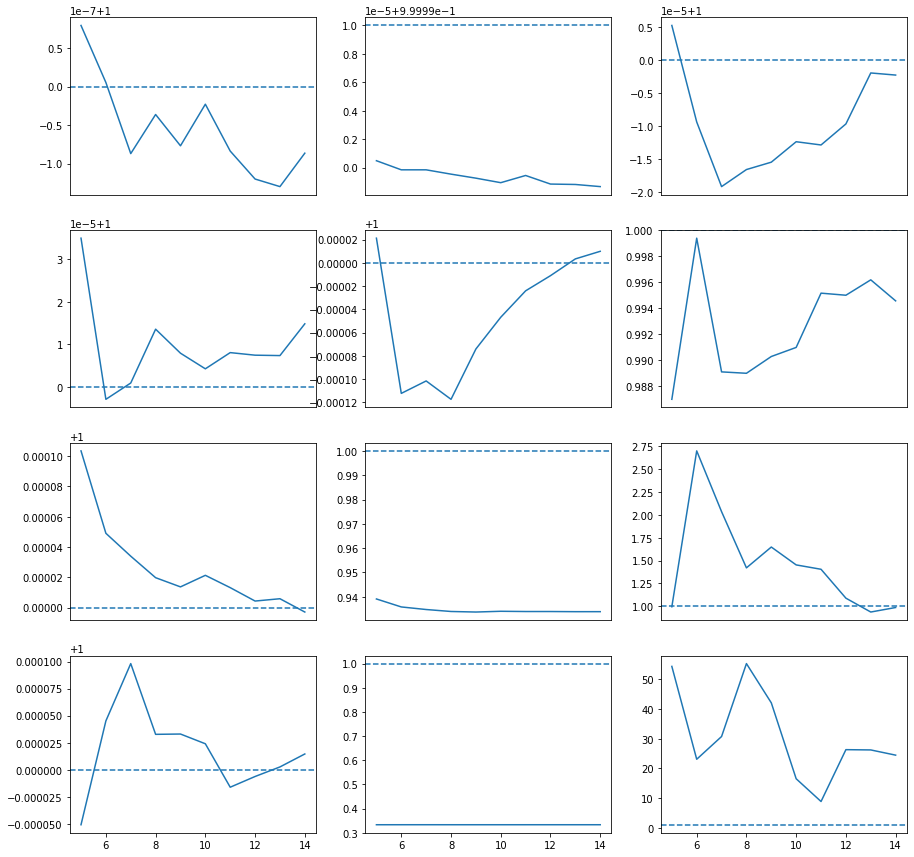

In [180]:
fig = plt.figure(figsize=(15,15))

for i, ndims in enumerate([2,4,6,8], 0):
    for j, func in enumerate(['f1','f2','f3'], 0):
        
        ax = fig.add_subplot(4,3, i*3+j+1)
        temp_xx = np.arange(5,15)
        temp_yy = b.loc[(b.func == func) & (b['ndims'] == ndims) & (b['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        
        ax.plot(temp_xx, temp_yy, label='vegas')
        ax.axhline(1, linestyle='--')
        # ax.legend()
        
        if i < 3:
            ax.set_xticks([])


### VFlow

In [255]:
# temp_arr = np.load('result/06_Comp_VFlow/f1_run2_fp_d8_means_sdevs.npy')
# compute_variance_weighted_result(temp_arr[0][2:], temp_arr[1][2:])

In [241]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_VFlow/f1_run2_fp',
    'f1_run2': 'result/06_Comp_VFlow/f1_run3_fp',
    'f1_run3': 'result/06_Comp_VFlow/f1_run4_fp',
    'f1_run4': 'result/06_Comp_VFlow/f1_run5_fp',
        
    'f2_run1': 'result/06_Comp_VFlow/f2_run1_fp',
    'f2_run2': 'result/06_Comp_VFlow/f2_run2_fp',
    'f2_run3': 'result/06_Comp_VFlow/f2_run3_fp',
    'f2_run4': 'result/06_Comp_VFlow/f2_run4_fp',
    'f2_run5': 'result/06_Comp_VFlow/f2_run5_fp',
    
    'f3_run1': 'result/06_Comp_VFlow/f3_run1_fp',
    'f3_run2': 'result/06_Comp_VFlow/f3_run2_fp',
    'f3_run3': 'result/06_Comp_VFlow/f3_run3_fp',
    'f3_run4': 'result/06_Comp_VFlow/f3_run4_fp',
    'f3_run5': 'result/06_Comp_VFlow/f3_run5_fp',
}

In [242]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [243]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
0,f1,8,15,10000000,2.247575e-11,2.149865e-11,4.651454e+10,155.955,53.635,3.511376e+07,0.000000,2
1,f1,6,15,10000000,9.998936e-01,7.624192e-05,1.395887e+00,115.598,38.837,9.851714e+00,0.362623,2
2,f1,4,15,10000000,9.999645e-01,5.794855e-05,6.128089e-01,79.671,26.558,6.537432e+00,0.685155,2
3,f1,2,15,10000000,9.999758e-01,3.948745e-05,6.130097e-01,42.394,14.124,9.525017e+00,0.390286,2
0,f1,8,15,10000000,9.999775e-01,1.048145e-04,2.145045e-01,155.163,53.400,6.574065e+00,0.681369,3
1,f1,6,15,10000000,9.999879e-01,7.536325e-05,1.599868e-01,115.072,38.427,6.289548e+00,0.710626,3
2,f1,4,15,10000000,1.000060e+00,5.793940e-05,1.043324e+00,79.682,26.655,1.249291e+00,0.998615,3
3,f1,2,15,10000000,9.999460e-01,3.948237e-05,1.368850e+00,42.339,14.202,4.667881e+00,0.862246,3
0,f1,8,15,10000000,1.000033e+00,1.303123e-04,2.553405e-01,155.592,53.472,7.445985e+00,0.590790,4
1,f1,6,15,10000000,9.999650e-01,7.495962e-05,4.665175e-01,115.578,38.569,9.348510e+00,0.405745,4


In [244]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'vflow'
agg_df  #.reset_index()

res_mean               res_err                \
                             mean        std       mean           std   
func ndim nitn neval                                                    
f1   2    15   10000000  0.999966   0.000030   0.000039  7.938279e-09   
     4    15   10000000  1.000025   0.000047   0.000058  9.448398e-09   
     6    15   10000000  0.999966   0.000053   0.000075  5.624837e-07   
     8    15   10000000  0.500003   0.577353   0.000059  6.866884e-05   
f2   2    15   10000000  1.000003   0.000214   0.000181  1.736280e-08   
     4    15   10000000  0.999479   0.000666   0.000731  7.815746e-07   
     6    15   10000000  0.867145   0.182802   0.001890  1.202225e-03   
     8    15   10000000  0.333317   0.000021   0.000038  4.397568e-06   
f3   2    15   10000000  0.997857   0.003064   0.003529  1.162281e-07   
     4    15   10000000  0.989146   0.032865   0.057251  1.561047e-06   
     6    15   10000000  0.184364   1.872581   1.438232  4.562427e-05   
     8    15   10000000 -0.640728  33.422988  51.850602  1.314786e-03   

                              res_rel               total_time            \
                                 mean           std       mean       std   
func ndim nitn neval                                                       
f1   2    15   10000000  9.082636e-01  6.889537e-01   42.47125  0.170171   
     4    15   10000000  7.322757e-01  4.243654e-01   79.69375  0.054586   
     6    15   10000000  5.690090e-01  5.659757e-01  115.44600  0.250668   
     8    15   10000000  2.094118e+24  4.188237e+24  155.47925  0.371118   
f2   2    15   10000000  9.939582e-01  4.171095e-01   45.05520  0.248912   
     4    15   10000000  7.728891e-01  8.490039e-01   83.28820  0.553484   
     6    15   10000000  2.319567e+02  3.170010e+02  120.02680  0.351737   
     8    15   10000000  1.765367e+04  1.796362e+03  161.61880  0.433624   
f3   2    15   10000000  7.486197e-01  7.173069e-01   42.45620  0.158339   
     4    15   10000000  5.332808e-01  1.377096e-01   79.76660  0.209873   
     6    15   10000000  1.170058e+00  6.212191e-01  115.68560  0.376084   
     8    15   10000000  4.808497e-01  3.574107e-01  155.32260  0.658852   

                         pre_time                    chi2                \
                             mean       std          mean           std   
func ndim nitn neval                                                      
f1   2    15   10000000  14.19900  0.072833  6.670564e+00  2.043532e+00   
     4    15   10000000  26.56675  0.060890  1.145107e+01  9.163302e+00   
     6    15   10000000  38.56975  0.188957  1.027166e+01  3.883455e+00   
     8    15   10000000  53.45300  0.139281  1.145411e+07  1.656036e+07   
f2   2    15   10000000  15.04800  0.094512  6.891755e+00  7.382121e-01   
     4    15   10000000  27.84380  0.222669  1.019023e+01  4.903904e+00   
     6    15   10000000  40.08600  0.150766  6.716643e+00  4.667587e+00   
     8    15   10000000  55.65200  0.267880  1.284667e+01  1.498797e+01   
f3   2    15   10000000  14.19660  0.077581  9.454898e+00  5.348327e+00   
     4    15   10000000  26.67000  0.081557  9.039667e+00  2.848394e+00   
     6    15   10000000  38.69280  0.284875  9.805349e+00  2.258999e+00   
     8    15   10000000  53.46340  0.146097  8.835976e+00  5.319004e+00   

                                Q            itype  
                             mean       std         
func ndim nitn neval                                
f1   2    15   10000000  0.670729  0.199458  vflow  
     4    15   10000000  0.436746  0.485269  vflow  
     6    15   10000000  0.388697  0.259819  vflow  
     8    15   10000000  0.318040  0.369098  vflow  
f2   2    15   10000000  0.648164  0.076144  vflow  
     4    15   10000000  0.423807  0.321588  vflow  
     6    15   10000000  0.657411  0.388226  vflow  
     8    15   10000000  0.567857  0.401713  vflow  
f3   2    15   10000000  0.488743  0.346989  vflow  
     4    15   10000000  0

#### Plot

In [181]:
temp_folder = 'result/06_Comp_VFlow'

In [182]:
[f for f in os.listdir(temp_folder) if f.endswith('.npy')][0]

'f1_run2_fp_d2_means_sdevs.npy'

In [183]:
stat_df = pd.DataFrame()

for fname in [f for f in os.listdir(temp_folder) if f.endswith('.npy')]:
    
    func, run_num, _, ndims, _, _ = fname.split('_')
    run_num = int(run_num[-1])
    ndims = int(ndims[-1])
    
    arr = np.load(os.path.join(temp_folder,fname))
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndims'] = ndims
    temp_df['run_num'] = run_num
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndims', 'itype', *range(10), 'run_num']]

In [184]:
stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9,run_num
0,f1,2,mean,1.000277,0.999856,0.999983,1.000046,0.999768,1.000049,1.000007,1.000114,0.999873,0.999923,2
1,f1,2,sdev,0.000194,0.000155,0.000133,0.000121,0.000115,0.000113,0.000113,0.000116,0.000118,0.000120,2
0,f1,4,mean,1.000232,0.999665,0.999975,0.999924,0.999849,0.999845,0.999934,1.000128,1.000210,0.999947,2
1,f1,4,sdev,0.000296,0.000230,0.000195,0.000176,0.000167,0.000165,0.000166,0.000169,0.000174,0.000177,2
0,f1,6,mean,1.000053,1.000041,0.999449,1.000360,1.000120,0.999814,0.999832,0.999671,0.999922,0.999776,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,f3,4,sdev,0.181056,0.181004,0.181022,0.181080,0.181061,0.181058,0.181082,0.181045,0.181040,0.181054,5
0,f3,6,mean,4.354109,-1.217511,9.251981,6.188305,-2.369796,-0.599532,-2.417781,-6.440341,3.267846,4.565051,5
1,f3,6,sdev,4.546918,4.548074,4.548415,4.547129,4.547617,4.547266,4.548752,4.548396,4.548030,4.547988,5
0,f3,8,mean,19.921791,50.405883,-297.491288,50.594629,297.164044,-111.931774,-0.135157,-171.407077,149.554789,113.132514,5


In [185]:
agg_stat_df = stat_df.groupby(['func', 'ndims', 'itype']).mean().reset_index().drop('run_num', axis=1)
agg_stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,0.999984,0.999842,1.000049,0.999934,0.999933,0.999943,1.000011,1.000033,0.999933,0.999970
1,f1,2,sdev,0.000194,0.000155,0.000133,0.000121,0.000115,0.000113,0.000113,0.000116,0.000118,0.000120
2,f1,4,mean,1.000206,0.999955,1.000036,0.999937,1.000047,0.999992,0.999970,0.999976,1.000117,1.000111
3,f1,4,sdev,0.000296,0.000231,0.000195,0.000176,0.000167,0.000165,0.000166,0.000169,0.000173,0.000177
4,f1,6,mean,0.999916,1.000074,0.999895,1.000291,0.999926,0.999843,0.999916,0.999940,0.999900,0.999998
5,f1,6,sdev,0.000424,0.000314,0.000258,0.000229,0.000215,0.000212,0.000214,0.000218,0.000224,0.000228
6,f1,8,mean,0.539550,0.502742,0.867308,0.749207,0.962789,1.000389,1.000810,0.999905,1.000065,0.999855
7,f1,8,sdev,0.030468,0.002043,0.166602,0.003407,0.035426,0.003205,0.000800,0.000461,0.000354,0.000306
8,f2,2,mean,1.000228,1.000164,1.000516,0.999971,0.999839,0.999948,0.999835,0.999459,1.000137,1.000054
9,f2,2,sdev,0.000646,0.000601,0.000577,0.000564,0.000558,0.000555,0.000555,0.000556,0.000558,0.000561


In [186]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(10)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(10)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,11)]
    w_arr = np.array(w_arr).T
    temp_df = pd.DataFrame(w_arr)
    return pd.concat([x[['func', 'ndims', 'itype']].reset_index(drop=True), temp_df], axis=1)#, ignore_index=True)

c = agg_stat_df.groupby(['func', 'ndims'], as_index=False).apply(temp_foo).reset_index(drop=True)
c

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,0.999984,0.999897,0.999966,0.999955,0.999949,0.999947,0.999959,0.999970,0.999965,0.999966
1,f1,2,sdev,0.000194,0.000121,0.000089,0.000072,0.000061,0.000054,0.000048,0.000045,0.000042,0.000039
2,f1,4,mean,1.000206,1.000050,1.000043,1.000005,1.000017,1.000011,1.000004,0.999999,1.000014,1.000025
3,f1,4,sdev,0.000296,0.000182,0.000133,0.000106,0.000090,0.000079,0.000071,0.000066,0.000061,0.000058
4,f1,6,mean,0.999916,1.000018,0.999958,1.000086,1.000037,0.999991,0.999977,0.999971,0.999962,0.999966
5,f1,6,sdev,0.000424,0.000252,0.000180,0.000142,0.000118,0.000103,0.000093,0.000086,0.000080,0.000075
6,f1,8,mean,0.539550,0.502907,0.502961,0.567869,0.568830,0.667722,0.929536,0.979022,0.990478,0.994422
7,f1,8,sdev,0.030468,0.002039,0.002039,0.001749,0.001747,0.001534,0.000710,0.000387,0.000261,0.000199
8,f2,2,mean,1.000228,1.000194,1.000313,1.000217,1.000134,1.000100,1.000059,0.999979,0.999997,1.000003
9,f2,2,sdev,0.000646,0.000440,0.000350,0.000297,0.000262,0.000237,0.000218,0.000203,0.000191,0.000181


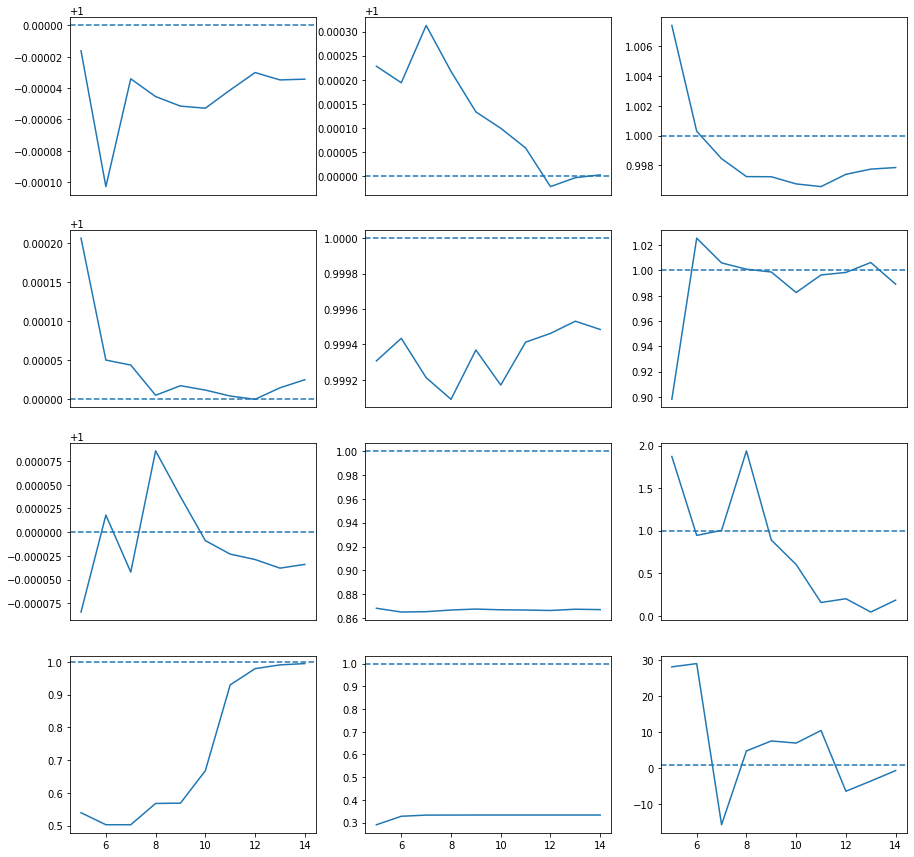

In [187]:
fig = plt.figure(figsize=(15,15))

for i, ndims in enumerate([2,4,6,8], 0):
    for j, func in enumerate(['f1','f2','f3'], 0):
        
        ax = fig.add_subplot(4,3, i*3+j+1)
        temp_xx = np.arange(5,15)
        temp_yy = c.loc[(c.func == func) & (c['ndims'] == ndims) & (c['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        
        ax.plot(temp_xx, temp_yy, label='vflow')
        ax.axhline(1, linestyle='--')
        # ax.legend()
        
        if i < 3:
            ax.set_xticks([])


### VFlowGPUSame

In [212]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_VFlowGPUSame/f1_run1_fp.csv',
    'f1_run2': 'result/06_Comp_VFlowGPUSame/f1_run2_fp.csv',
    'f1_run3': 'result/06_Comp_VFlowGPUSame/f1_run3_fp.csv',
        
    'f2_run1': 'result/06_Comp_VFlowGPUSame/f2_run1_fp.csv',
    'f2_run2': 'result/06_Comp_VFlowGPUSame/f2_run2_fp.csv',
    'f2_run3': 'result/06_Comp_VFlowGPUSame/f2_run3_fp.csv',
    
    'f3_run1': 'result/06_Comp_VFlowGPUSame/f3_run1_fp.csv',
    'f3_run2': 'result/06_Comp_VFlowGPUSame/f3_run2_fp.csv',
    'f3_run3': 'result/06_Comp_VFlowGPUSame/f3_run3_fp.csv',
}

In [213]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [214]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
0,f1,8,15,10000000,1.065498e-01,4.922382e-05,1.815077e+04,27.538,11.095,3.925941e+07,0.000000,1
1,f1,6,15,10000000,9.999971e-01,7.503201e-05,3.873166e-02,19.274,6.455,4.581735e+00,0.869141,1
2,f1,4,15,10000000,9.999887e-01,5.791487e-05,1.958547e-01,14.434,4.878,3.550280e+00,0.938448,1
3,f1,2,15,10000000,9.999869e-01,3.950030e-05,3.307046e-01,8.290,2.828,7.554798e+00,0.579557,1
0,f1,8,15,10000000,1.450997e-09,1.386689e-09,7.211423e+08,27.116,10.965,3.343642e+07,0.000000,2
1,f1,6,15,10000000,1.000001e+00,7.586090e-05,1.661407e-02,19.471,6.569,1.288301e+01,0.167972,2
2,f1,4,15,10000000,9.999452e-01,5.792872e-05,9.461336e-01,14.429,4.868,6.033747e+00,0.736536,2
3,f1,2,15,10000000,9.999358e-01,3.947722e-05,1.627488e+00,8.272,2.815,4.994474e+00,0.834790,2
0,f1,8,15,10000000,9.999834e-01,1.314398e-04,1.260216e-01,26.891,10.734,1.387507e+01,0.126839,3
1,f1,6,15,10000000,1.000063e+00,7.492832e-05,8.452817e-01,19.211,6.490,1.585571e+01,0.069956,3


In [215]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'vflow'
agg_df  #.reset_index()

res_mean               res_err                \
                              mean        std       mean           std   
func ndim nitn neval                                                     
f1   2    15   10000000   0.999968   0.000028   0.000039  1.277900e-08   
     4    15   10000000   0.999991   0.000047   0.000058  1.731972e-08   
     6    15   10000000   1.000021   0.000037   0.000075  5.111289e-07   
     8    15   10000000   0.368844   0.549173   0.000060  6.640581e-05   
f2   2    15   10000000   0.999964   0.000052   0.000181  4.411671e-09   
     4    15   10000000   0.999399   0.000424   0.000731  5.801128e-07   
     6    15   10000000   0.777734   0.192582   0.001293  1.242778e-03   
     8    15   10000000   0.333324   0.000031   0.000039  4.736395e-06   
f3   2    15   10000000   0.996876   0.002221   0.003529  3.691230e-08   
     4    15   10000000   0.966170   0.068468   0.057251  1.973733e-06   
     6    15   10000000   1.433280   1.464139   1.438205  1.765714e-05   
     8    15   10000000 -20.011496  11.605103  51.849966  2.393217e-03   

                              res_rel               total_time            \
                                 mean           std       mean       std   
func ndim nitn neval                                                       
f1   2    15   10000000  8.175511e-01  7.061886e-01   8.277000  0.011358   
     4    15   10000000  6.039674e-01  3.794619e-01  14.420000  0.020075   
     6    15   10000000  3.002091e-01  4.721762e-01  19.318667  0.135633   
     8    15   10000000  2.403868e+08  4.163465e+08  27.181667  0.328461   
f2   2    15   10000000  2.300602e-01  2.499739e-01   8.322333  0.014012   
     4    15   10000000  8.219250e-01  5.809192e-01  14.445667  0.011240   
     6    15   10000000  3.863178e+02  3.346423e+02  20.287000  0.182978   
     8    15   10000000  1.717602e+04  2.032894e+03  28.199000  0.103116   
f3   2    15   10000000  8.852114e-01  6.295116e-01   8.252000  0.010817   
     4    15   10000000  1.008359e+00  6.548603e-01  14.401333  0.015885   
     6    15   10000000  7.422550e-01  5.883360e-01  19.397667  0.025658   
     8    15   10000000  4.052354e-01  2.238241e-01  27.097000  0.142790   

                          pre_time                    chi2                \
                              mean       std          mean           std   
func ndim nitn neval                                                       
f1   2    15   10000000   2.819000  0.007810  7.156878e+00  1.993455e+00   
     4    15   10000000   4.869000  0.008544  5.581058e+00  1.846531e+00   
     6    15   10000000   6.504667  0.058398  1.110682e+01  5.843098e+00   
     8    15   10000000  10.931333  0.182840  2.423195e+07  2.118648e+07   
f2   2    15   10000000   2.861333  0.010116  9.046853e+00  4.096481e+00   
     4    15   10000000   4.908000  0.004583  1.186065e+01  5.756661e+00   
     6    15   10000000   6.858333  0.034530  5.837369e+00  1.921089e+00   
     8    15   10000000  11.286333  0.126950  5.880009e+00  1.428095e+00   
f3   2    15   10000000   2.798333  0.004041  1.180885e+01  4.141811e+00   
     4    15   10000000   4.853000  0.001732  1.497031e+01  5.627205e+00   
     6    15   10000000   6.530000  0.015716  7.383519e+00  3.477944e+00   
     8    15   10000000  10.828333  0.073793  1.012508e+01  2.874148e+00   

                                Q            itype  
                             mean       std         
func ndim nitn neval                                
f1   2    15   10000000  0.619637  0.198176  vflow  
     4    15   10000000  0.765179  0.160871  vflow  
     6    15   10000000  0.369023  0.435878  vflow  
     8    15   10000000  0.042280  0.073231  vflow  
f2   2    15   10000000  0.462211  0.369854  vflow  
     4    15   10000000  0.330188  0.359560  vflow  
     6    15   10000000  0.746858  0.187505  vflow  
     8    15   10000000  0.745391  0.137191  vflow  
f3   2    15   10000000  0.288368  0.299274  vflow

### VFlowGPUX10

In [204]:
stat_df_dict ={
#     'f1_run1': 'result/06_Comp_VFlowGPUSame/f1_run1_fp.csv',
    'f1_run2': 'result/06_Comp_VFlowGPUSameX10/f1_run2_fp.csv',
    'f1_run3': 'result/06_Comp_VFlowGPUSameX10/f1_run3_fp.csv',
        
    'f2_run1': 'result/06_Comp_VFlowGPUSameX10/f2_run1_fp.csv',
    'f2_run2': 'result/06_Comp_VFlowGPUSameX10/f2_run2_fp.csv',
    'f2_run3': 'result/06_Comp_VFlowGPUSameX10/f2_run3_fp.csv',
    
    'f3_run1': 'result/06_Comp_VFlowGPUSameX10/f3_run1_fp.csv',
    'f3_run2': 'result/06_Comp_VFlowGPUSameX10/f3_run2_fp.csv',
    'f3_run3': 'result/06_Comp_VFlowGPUSameX10/f3_run3_fp.csv',
}

In [205]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [206]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
0,f1,8,15,100000000,1.000001,0.000030,0.023528,226.405,77.164,13.377795,0.146243,2
1,f1,6,15,100000000,0.999959,0.000023,1.731380,177.834,59.362,5.791325,0.760608,2
2,f1,4,15,100000000,1.000001,0.000018,0.068749,132.981,44.384,8.010065,0.533132,2
3,f1,2,15,100000000,0.999987,0.000012,1.045807,77.026,25.733,12.680934,0.177583,2
0,f1,8,15,100000000,1.000037,0.000031,1.216105,226.186,77.220,10.766145,0.292080,3
1,f1,6,15,100000000,0.999985,0.000023,0.641270,178.979,59.677,8.476390,0.486939,3
2,f1,4,15,100000000,1.000016,0.000018,0.850518,132.983,44.387,10.781397,0.290991,3
3,f1,2,15,100000000,0.999997,0.000012,0.227607,76.973,25.705,3.652943,0.932736,3
0,f2,8,15,100000000,0.333343,0.000010,67463.393902,236.938,80.886,10.608379,0.303510,1
1,f2,6,15,100000000,0.999443,0.000832,0.669221,185.372,61.704,13.185938,0.154372,1


In [207]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg([np.mean, np.std])\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'vflow'
agg_df  #.reset_index()

res_mean               res_err                \
                              mean        std       mean           std   
func ndim nitn neval                                                     
f1   2    15   100000000  0.999992   0.000007   0.000012  8.200123e-11   
     4    15   100000000  1.000008   0.000010   0.000018  9.307149e-10   
     6    15   100000000  0.999972   0.000018   0.000023  1.971990e-08   
     8    15   100000000  1.000019   0.000026   0.000030  6.342677e-07   
f2   2    15   100000000  0.999976   0.000064   0.000057  2.059381e-09   
     4    15   100000000  0.999821   0.000297   0.000231  2.295578e-08   
     6    15   100000000  1.000093   0.000714   0.000840  6.716045e-06   
     8    15   100000000  0.333344   0.000012   0.000010  9.720687e-08   
f3   2    15   100000000  0.999058   0.000908   0.001116  3.222391e-09   
     4    15   100000000  0.981183   0.011462   0.018104  3.420225e-07   
     6    15   100000000  0.618607   0.048641   0.454811  3.860213e-06   
     8    15   100000000 -9.956710  15.298409  16.396276  1.366563e-04   

                               res_rel              total_time            \
                                  mean         std        mean       std   
func ndim nitn neval                                                       
f1   2    15   100000000      0.636707    0.578555   76.999500  0.037477   
     4    15   100000000      0.459634    0.552794  132.982000  0.001414   
     6    15   100000000      1.186325    0.770824  178.406500  0.809637   
     8    15   100000000      0.619817    0.843280  226.295500  0.154856   
f2   2    15   100000000      0.750121    0.824345   77.123000  0.149439   
     4    15   100000000      0.972997    1.062703  133.118667  0.144680   
     6    15   100000000      0.569737    0.501496  186.726667  1.184308   
     8    15   100000000  66710.938443  652.607597  236.633000  0.369582   
f3   2    15   100000000      0.844153    0.813474   76.691000  0.188351   
     4    15   100000000      1.039349    0.633113  132.998333  0.071619   
     6    15   100000000      0.838575    0.106955  177.378667  0.426420   
     8    15   100000000      0.668244    0.933044  225.384667  0.571133   

                           pre_time                 chi2                   Q  \
                               mean       std       mean       std      mean   
func ndim nitn neval                                                           
f1   2    15   100000000  25.719000  0.019799   8.166938  6.383754  0.555160   
     4    15   100000000  44.385500  0.002121   9.395731  1.959627  0.412062   
     6    15   100000000  59.519500  0.222739   7.133858  1.898628  0.623774   
     8    15   100000000  77.192000  0.039598  12.071970  1.846716  0.219161   
f2   2    15   100000000  25.800333  0.052776   8.481002  2.342721  0.496796   
     4    15   100000000  44.467000  0.035763   8.012385  3.993680  0.532397   
     6    15   100000000  62.342667  0.553146  10.463437  2.367663  0.336885   
     8    15   100000000  80.805667  0.132274   8.911237  1.522582  0.453412   
f3   2    15   100000000  25.617000  0.053694  10.341298  3.331694  0.362539   
     4    15   100000000  44.385667  0.020429   9.023120  2.808968  0.458954   
     6    15   100000000  59.227333  0.128220   8.498086  2.433358  0.498178   
     8    15   100000000  76.990667  0.214610   9.810611  4.942944  0.432284   

                                    itype  
                               std         
func ndim nitn neval                       
f1   2    15   100000000  0.533974  vflow  
     4    15   100000000  0.171219  vflow  
     6    15   100000000  0.193513  vflow  
     8    15   100000000  0.103122  vflow  
f2   2    15   100000000  0.229773  vflow  
     4    15   100000000  0.358447  vflow  
     6    15   100000000  0.159289  vflow  
     8    15   100000000  0.135798  vflow  
f3   2    15   100000000  0.281663  vflow  
     4    15   100000000  0.247864  vflow  
 

#### Plot

In [198]:
temp_folder = 'result/06_Comp_VFlowGPUSameX10'

In [199]:
[f for f in os.listdir(temp_folder) if f.endswith('.npy')][0]

'f1_run1_fp_d2_means_sdevs.npy'

In [200]:
stat_df = pd.DataFrame()

for fname in [f for f in os.listdir(temp_folder) if f.endswith('.npy')]:
    
    func, run_num, _, ndims, _, _ = fname.split('_')
    run_num = int(run_num[-1])
    ndims = int(ndims[-1])
    
    arr = np.load(os.path.join(temp_folder,fname))
    temp_df = pd.DataFrame(arr[:2])
    temp_df['func'] = func
    temp_df['ndims'] = ndims
    temp_df['run_num'] = run_num
    temp_df['itype'] = ['mean', 'sdev']
    
    stat_df = pd.concat([stat_df, temp_df])
    
stat_df = stat_df[['func', 'ndims', 'itype', *range(10), 'run_num']]

In [201]:
stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9,run_num
0,f1,2,mean,0.999969,0.999945,0.999984,1.000013,1.000013,1.000000,1.000014,1.000038,0.999987,1.000009,1
1,f1,2,sdev,0.000062,0.000049,0.000042,0.000038,0.000036,0.000036,0.000036,0.000036,0.000037,0.000038,1
0,f1,4,mean,1.000140,1.000045,1.000094,0.999991,1.000017,0.999971,0.999975,0.999968,1.000004,0.999976,1
1,f1,4,sdev,0.000094,0.000073,0.000062,0.000056,0.000053,0.000052,0.000052,0.000053,0.000055,0.000056,1
0,f1,6,mean,1.000253,1.000009,1.000090,0.999996,1.000155,1.000133,0.999926,0.999960,0.999961,0.999824,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,f3,4,sdev,0.057256,0.057252,0.057248,0.057252,0.057253,0.057251,0.057251,0.057252,0.057251,0.057250,3
0,f3,6,mean,-0.116662,1.780731,0.904671,1.831894,1.266695,-1.616678,1.108902,0.037682,1.852309,-0.508840,3
1,f3,6,sdev,1.438222,1.438233,1.438204,1.438321,1.438202,1.438257,1.438338,1.438192,1.438247,1.438174,3
0,f3,8,mean,-18.830375,-102.168068,-26.610946,50.622848,72.468633,-4.460391,-76.063669,10.395102,48.524314,15.033087,3


In [202]:
agg_stat_df = stat_df.groupby(['func', 'ndims', 'itype']).mean().reset_index().drop('run_num', axis=1)
agg_stat_df

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000032,0.999987,0.999985,1.000015,0.999967,1.000006,1.000007,1.000001,0.999986,0.999988
1,f1,2,sdev,0.000062,0.000049,0.000042,0.000038,0.000036,0.000036,0.000036,0.000036,0.000037,0.000038
2,f1,4,mean,1.000071,1.000003,1.000048,0.999993,0.999985,1.000046,0.999982,1.000009,0.999969,1.000015
3,f1,4,sdev,0.000094,0.000073,0.000062,0.000056,0.000053,0.000052,0.000052,0.000053,0.000055,0.000056
4,f1,6,mean,1.000144,0.999999,1.000022,0.999992,1.000077,1.000012,0.999889,0.999977,0.999962,0.999910
5,f1,6,sdev,0.000126,0.000095,0.000079,0.000071,0.000067,0.000066,0.000067,0.000068,0.000070,0.000071
6,f1,8,mean,1.000291,0.999881,1.000180,1.000032,1.000012,0.999955,1.000086,1.000032,0.999980,1.000002
7,f1,8,sdev,0.000249,0.000156,0.000116,0.000097,0.000086,0.000082,0.000081,0.000082,0.000084,0.000085
8,f2,2,mean,0.999805,0.999888,1.000104,1.000156,0.999976,0.999942,1.000008,1.000018,0.999965,0.999856
9,f2,2,sdev,0.000204,0.000190,0.000183,0.000178,0.000176,0.000176,0.000176,0.000176,0.000177,0.000177


In [203]:
def temp_foo(x):
    means = x.loc[x.itype == 'mean', [*range(10)]].values.flatten()
    sdevs = x.loc[x.itype == 'sdev', [*range(10)]].values.flatten()
    w_arr = [compute_variance_weighted_result(means[:i], sdevs[:i]) for i in range(1,11)]
    w_arr = np.array(w_arr).T
    temp_df = pd.DataFrame(w_arr)
    return pd.concat([x[['func', 'ndims', 'itype']].reset_index(drop=True), temp_df], axis=1)#, ignore_index=True)

c = agg_stat_df.groupby(['func', 'ndims'], as_index=False).apply(temp_foo).reset_index(drop=True)
c

,func,ndims,itype,0,1,2,3,4,5,6,7,8,9
0,f1,2,mean,1.000032,1.000004,0.999995,1.000002,0.999992,0.999995,0.999997,0.999998,0.999996,0.999996
1,f1,2,sdev,0.000062,0.000038,0.000028,0.000023,0.000019,0.000017,0.000015,0.000014,0.000013,0.000012
2,f1,4,mean,1.000071,1.000029,1.000038,1.000022,1.000011,1.000019,1.000012,1.000012,1.000006,1.000007
3,f1,4,sdev,0.000094,0.000058,0.000042,0.000034,0.000028,0.000025,0.000023,0.000021,0.000019,0.000018
4,f1,6,mean,1.000144,1.000052,1.000037,1.000020,1.000037,1.000031,1.000005,1.000001,0.999996,0.999986
5,f1,6,sdev,0.000126,0.000076,0.000055,0.000043,0.000036,0.000032,0.000029,0.000027,0.000025,0.000023
6,f1,8,mean,1.000291,0.999998,1.000100,1.000070,1.000049,1.000022,1.000036,1.000036,1.000027,1.000024
7,f1,8,sdev,0.000249,0.000132,0.000087,0.000065,0.000052,0.000044,0.000039,0.000035,0.000032,0.000030
8,f2,2,mean,0.999805,0.999849,0.999943,1.000002,0.999996,0.999986,0.999990,0.999994,0.999990,0.999976
9,f2,2,sdev,0.000204,0.000139,0.000111,0.000094,0.000083,0.000075,0.000069,0.000064,0.000060,0.000057


### IFlow

In [26]:
stat_df_dict ={
    'f1_run1': 'result/06_Comp_IFlow/f1_run1_fp',
#     'f1_run2': 'result/06_Comp_IFlow/f1_run3_fp',
#     'f1_run3': 'result/06_Comp_IFlow/f1_run4_fp',
        
    'f2_run1': 'result/06_Comp_IFlow/f2_run1_fp',
#     'f2_run2': 'result/06_Comp_IFlow/f2_run2_fp',
#     'f2_run3': 'result/06_Comp_IFlow/f2_run3_fp',
    
#     'f3_run1': 'result/06_Comp_IFlow/f3_run1_fp',
#     'f3_run2': 'result/06_Comp_IFlow/f3_run2_fp',
#     'f3_run3': 'result/06_Comp_IFlow/f3_run3_fp',
}

In [27]:
stat_df = pd.DataFrame()

for k,v in stat_df_dict.items():
    
    temp_df = pd.read_csv(v)    
    stat_df = pd.concat([stat_df, temp_df])
    
    # stat_df['itype'] = 'vegas'

In [28]:
stat_df

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
0,f1,8,15,100000,2.207104e-74,1.745548e-74,5.728859e+73,1211.756,435.902,8.403080,0.494090,1
1,f1,6,15,100000,2.472900e-34,2.472543e-34,4.044419e+33,802.951,274.255,9.560814,0.387194,1
2,f1,4,15,100000,1.701274e-02,7.593766e-03,1.294466e+02,266.679,95.539,8.702137,0.465211,1
3,f1,2,15,100000,9.988983e-01,2.584107e-02,4.263367e-02,69.900,25.636,2.725535,0.974191,1
0,f2,8,15,100000,2.063970e-79,2.063969e-79,4.845035e+78,1324.350,441.444,9.565843,0.386761,1
1,f2,6,15,100000,1.224094e-20,1.175053e-20,8.510256e+19,794.027,280.241,9.649257,0.379619,1
2,f2,4,15,100000,2.125339e-02,1.111930e-02,8.802236e+01,260.547,93.647,14.719119,0.098946,1
3,f2,2,15,100000,1.019248e+00,1.511889e-02,1.273083e+00,69.843,25.484,12.680463,0.177606,1


In [31]:
temp_cols = ['func', 'ndim', 'nitn', 'neval']
agg_df = stat_df.groupby(temp_cols, as_index=False)\
    .agg(np.mean,)\
    .drop(['run_num'], axis=1)

agg_df['itype'] = 'iflow'
agg_df.drop(['res_rel', 'pre_time', 'chi2', 'Q', 'itype'],axis=1)  #.reset_index()

,func,ndim,nitn,neval,res_mean,res_err,total_time
0,f1,2,15,100000,9.988983e-01,2.584107e-02,69.900
1,f1,4,15,100000,1.701274e-02,7.593766e-03,266.679
2,f1,6,15,100000,2.472900e-34,2.472543e-34,802.951
3,f1,8,15,100000,2.207104e-74,1.745548e-74,1211.756
4,f2,2,15,100000,1.019248e+00,1.511889e-02,69.843
5,f2,4,15,100000,2.125339e-02,1.111930e-02,260.547
6,f2,6,15,100000,1.224094e-20,1.175053e-20,794.027
7,f2,8,15,100000,2.063970e-79,2.063969e-79,1324.350


### General Convergence Plot

In [ ]:
# a, b, c

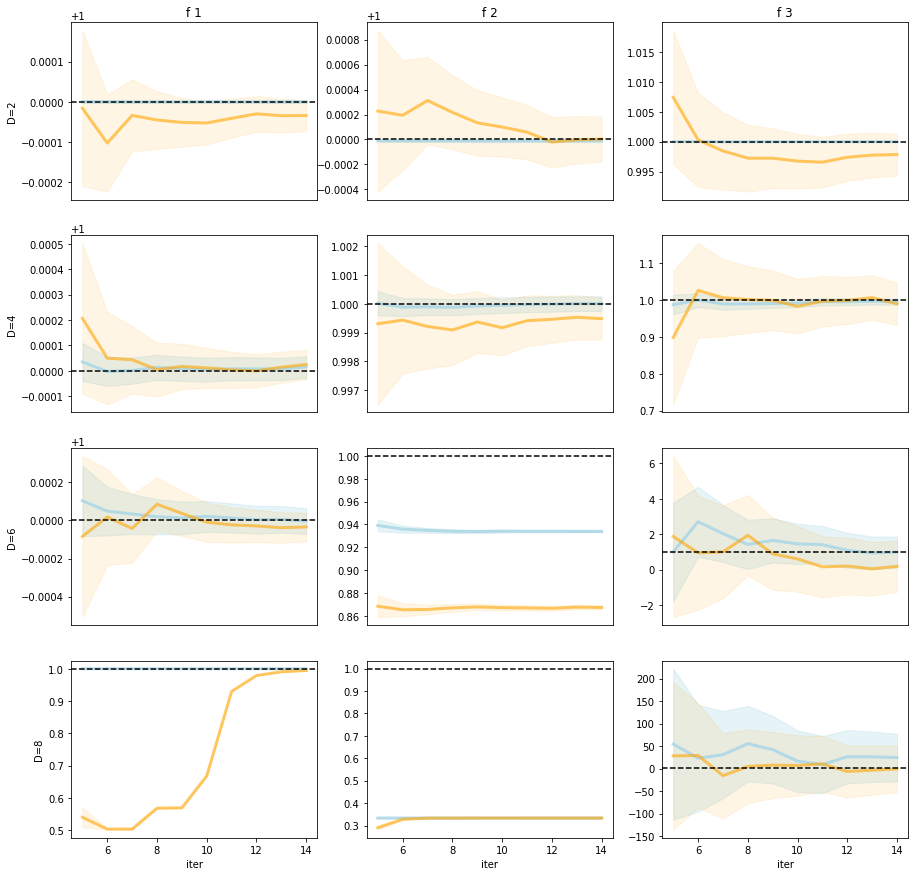

In [236]:
fig = plt.figure(figsize=(15,15))

for i, ndims in enumerate([2,4,6,8], 0):
    for j, func in enumerate(['f1','f2','f3'], 0):
        
        ax = fig.add_subplot(4,3, i*3+j+1)
        temp_xx = np.arange(5,15)
        temp_yy_sobol = a.loc[(a.func == func)
                              & (a['ndims'] == ndims)
                              & (a['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        temp_yy_sobol_sigma = a.loc[(a.func == func)
                                    & (a['ndims'] == ndims)
                                    & (a['itype'] == 'sdev')].iloc[:, 3:].values.flatten()
        
        temp_yy_vegas = b.loc[(b.func == func)
                              & (b['ndims'] == ndims)
                              & (b['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        temp_yy_vegas_sigma = b.loc[(b.func == func)
                                    & (b['ndims'] == ndims)
                                    & (b['itype'] == 'sdev')].iloc[:, 3:].values.flatten()
        
        temp_yy_vflow = c.loc[(c.func == func)
                              & (c['ndims'] == ndims)
                              & (c['itype'] == 'mean')].iloc[:, 3:].values.flatten()
        temp_yy_vflow_sigma = c.loc[(c.func == func)
                                    & (c['ndims'] == ndims)
                                    & (c['itype'] == 'sdev')].iloc[:, 3:].values.flatten()
        
        
        # ax.plot(temp_xx, temp_yy_sobol, label='sobol', color='blue')
        ax.plot(temp_xx, temp_yy_vegas, label='vegas', color='lightblue', linewidth=3, alpha=0.9)
        ax.fill_between(temp_xx,
                        temp_yy_vegas-temp_yy_vegas_sigma,
                        temp_yy_vegas+temp_yy_vegas_sigma,
                        color='lightblue',
                        alpha=.3)
        
        ax.plot(temp_xx, temp_yy_vflow, label='vflow', color='orange', linewidth=3, alpha=0.6)
        ax.fill_between(temp_xx,
                        temp_yy_vflow-temp_yy_vflow_sigma,
                        temp_yy_vflow+temp_yy_vflow_sigma,
                        color='orange',
                        alpha=.1)
        
        
        ax.axhline(1, linestyle='--', color='black')
        # ax.legend()
        
        if i < 3:
            ax.set_xticks([])
        else:
            ax.set_xlabel('iter')
        if i == 0:
            ax.set_title(f'f {func[-1]}')
        if j == 0:
            ax.set_ylabel(f'D={ndims}')

In [238]:
fig.savefig('result/06_Comp_Vegas/convergence.png', format='png', bbox_inches='tight')

In [240]:
pd.read_csv('result/06_Comp_VFlowGPUSame/f1_run1_fp.csv').sort_values(['ndim'])

,func,ndim,nitn,neval,res_mean,res_err,res_rel,total_time,pre_time,chi2,Q,run_num
3,f1,2,15,10000000,0.999987,0.000040,0.330705,8.290,2.828,7.554798e+00,0.579557,1
2,f1,4,15,10000000,0.999989,0.000058,0.195855,14.434,4.878,3.550280e+00,0.938448,1
1,f1,6,15,10000000,0.999997,0.000075,0.038732,19.274,6.455,4.581735e+00,0.869141,1
0,f1,8,15,10000000,0.106550,0.000049,18150.770038,27.538,11.095,3.925941e+07,0.000000,1
